## Stream

In [48]:
from py.streams import newStream
import pandas as pd

inicio = 25000
fim = 28000
quantidade = fim - inicio
MAX_INSTANCES = quantidade

df = pd.read_csv(
    'Teste_DNS_UDP.csv', 
    skiprows=range(1, inicio), 
    nrows=quantidade
)

stream, nomes_classes, features_usadas = newStream(
    df=df, 
    target_label_col='Label', 
    remove_redundant=False,
    selected_features=None,
    binary_label=True
)



# Acumulativo

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation import AnomalyDetectionEvaluator

def acumulative(WARMUP):
    schema = stream.get_schema()
    learner = OnlineIsolationForest(schema=schema) 
    evaluator = AnomalyDetectionEvaluator(schema)

    history = {
        'instances': [],
        'auc': [],
        'accuracy': []
    }
    
    attack_regions = []
    in_attack = False
    start_attack = 0

    count = 0
    stream.restart()

    while stream.has_more_instances() or count < MAX_INSTANCES:
        instance = stream.next_instance()
        is_attack = (instance.y_index == 1) 
        
        if is_attack and not in_attack:
            in_attack = True
            start_attack = count
        elif not is_attack and in_attack:
            in_attack = False
            attack_regions.append((start_attack, count))
        
        # WARM-UP
        if count < WARMUP:
            learner.train(instance)
            
        # AVALIAÇÃO + TREINO
        else:
            # Score
            proba = learner.score_instance(instance)
            
            # Atualiza Avaliador
            evaluator.update(instance.y_index, proba)
            
            # Coleta de métricas
            try:
                metrics = evaluator.metrics_dict()
                
                # Só salva se a AUC for válida 
                if 'auc' in metrics and not np.isnan(metrics['auc']):
                    history['instances'].append(count)
                    history['auc'].append(metrics['auc'])
                    history['accuracy'].append(metrics.get('Accuracy', 0.0))
                    
            except Exception:
                pass
                
            # Treina
            learner.train(instance)

        count += 1
        
    if in_attack:
        attack_regions.append((start_attack, count))

    plt.figure(figsize=(14, 6))
    plt.plot(history['instances'], history['accuracy'], color='#2ca02c', linewidth=2.0, label='Acurácia')
    plt.plot(history['instances'], history['auc'], color='#1f77b4', linewidth=2.0, label='AUC')
    
    for start, end in attack_regions:
        plt.axvspan(start, end, facecolor='red', alpha=0.15, edgecolor='none', label='Região de Ataque (Real)')

    plt.title("Desempenho Acumulativo")
    plt.xlabel("Instâncias")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Limiar de treinamento Janelado

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from sklearn.metrics import roc_auc_score, accuracy_score
from capymoa.anomaly import OnlineIsolationForest

def slidingWindow(WINDOW_SIZE, WARMUP, PROTECTION_THRESHOLD=0.0):
    schema = stream.get_schema()
    learner = OnlineIsolationForest(schema=schema)
    
    # Buffers
    window_y_true = deque(maxlen=WINDOW_SIZE)
    window_y_score = deque(maxlen=WINDOW_SIZE)
    
    history = {
        'instances': [],
        'auc_window': [],
        'acc_window': []
    }
    
    # Variáveis para pintar o fundo
    attack_regions = []
    in_attack = False
    start_attack = 0
    
    count = 0
    stream.restart()
    
    while stream.has_more_instances():
        instance = stream.next_instance()
        
        # Detectar inicio/fim de ataques para o gráfico
        is_attack = (instance.y_index == 1)
        
        if is_attack and not in_attack:
            in_attack = True
            start_attack = count
        elif not is_attack and in_attack:
            in_attack = False
            attack_regions.append((start_attack, count))
            
        # Obter Score
        proba = learner.score_instance(instance)
        
        if count < WARMUP:
            # Fase de Aquecimento: Treina tudo
            learner.train(instance)
        else:
            # Se Threshold for 0.0, desativa a proteção
            if PROTECTION_THRESHOLD == 0.0:
                learner.train(instance)
            # Se tiver proteção ativa, só treina se o score for baixo 
            elif proba < PROTECTION_THRESHOLD:
                learner.train(instance)
            else:
                pass

        # Atualizar Janela Deslizante
        if count >= WARMUP:
            window_y_true.append(instance.y_index)
            window_y_score.append(proba)
        
        # Cálculo de Métricas
        auc_now = np.nan
        acc_now = np.nan
        
        if len(window_y_true) == WINDOW_SIZE:
            try:
                # AUC 
                if len(set(window_y_true)) > 1:
                    auc_now = roc_auc_score(window_y_true, window_y_score)

                # Acurácia 
                preds = [1 if p > 0.5 else 0 for p in window_y_score]
                acc_now = accuracy_score(window_y_true, preds)
            except ValueError:
                pass 
        
        # Registro
        history['instances'].append(count)
        history['auc_window'].append(auc_now)
        history['acc_window'].append(acc_now)
        
        count += 1

    # Fecha região se terminar durante ataque
    if in_attack:
        attack_regions.append((start_attack, count))

    # PLOTAGEM Completa
    plt.figure(figsize=(14, 6))
    plt.plot(history['instances'], history['acc_window'], label='Acurácia (Contínua)', color='#2ca02c', linewidth=2.0)
    plt.plot(history['instances'], history['auc_window'], label='AUC (Intermitente)', color='#1f77b4', linewidth=2.0)
    for start, end in attack_regions:
        plt.axvspan(start, end, facecolor='red', alpha=0.15, label='Região de Ataque', edgecolor='none', linewidth=0)
    plt.title(f"Performance em Janela ({WINDOW_SIZE})", fontsize=14)
    plt.xlabel("Instâncias", fontsize=12)
    plt.ylabel("Métricas", fontsize=12)
    plt.ylim(-0.05, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='lower left', frameon=True, fontsize=10)
    plt.tight_layout()
    plt.show()

    # PLOTAGEM Zoom
    plt.figure(figsize=(14, 6))
    plt.plot(history['instances'], history['acc_window'], label='Acurácia (Contínua)', color='#2ca02c', linewidth=2.0)
    plt.plot(history['instances'], history['auc_window'], label='AUC (Intermitente)', color='#1f77b4', linewidth=2.0)
    
    for start, end in attack_regions:
        plt.axvspan(start, end, facecolor='red', alpha=0.15, edgecolor='none', label='Região de Ataque')
    
    if attack_regions:
        first_attack_start = attack_regions[0][0]
        last_attack_end = attack_regions[-1][1]
        margin = 200
        plt.xlim(first_attack_start - margin, last_attack_end + margin)

    plt.title(f"Detalhe do Evento de Ataque Janelado", fontsize=14)
    plt.xlabel("Instâncias", fontsize=12)
    plt.ylabel("Métricas", fontsize=12)
    plt.ylim(-0.05, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='best')
    plt.tight_layout()
    plt.show()

# Execução

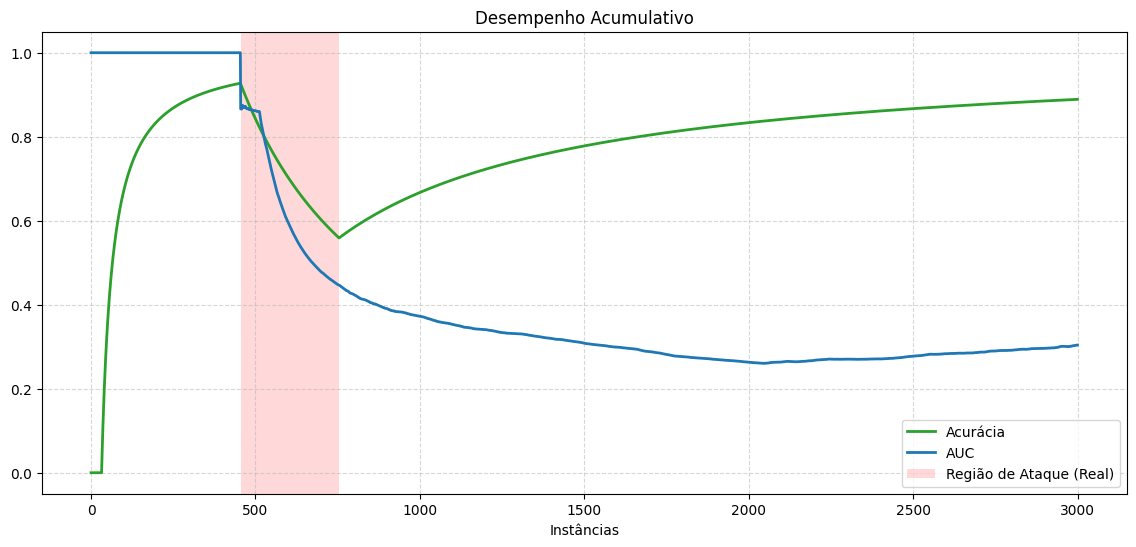

In [58]:
acumulative(
    WARMUP=0
)

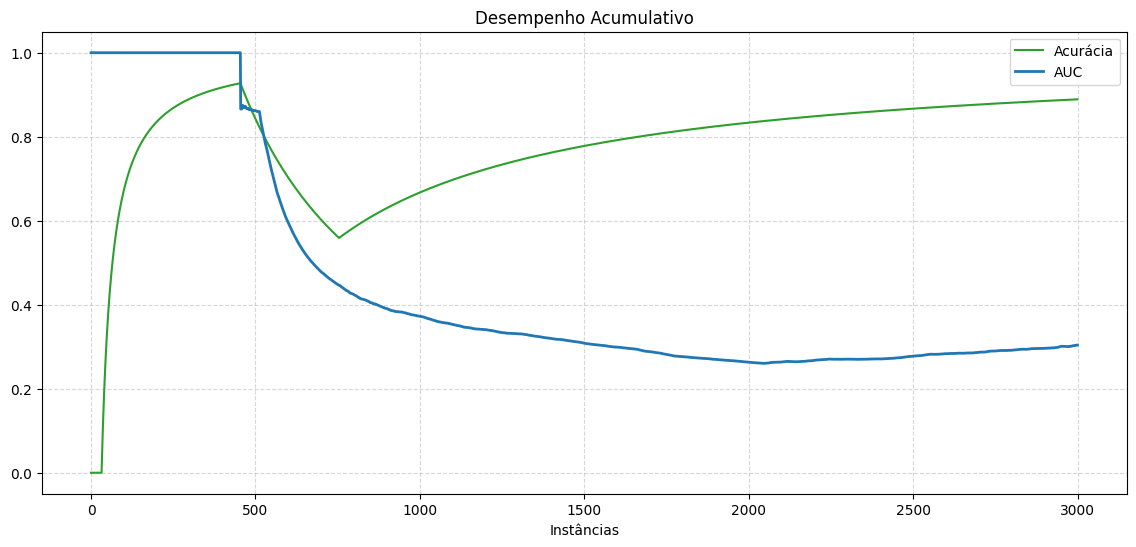

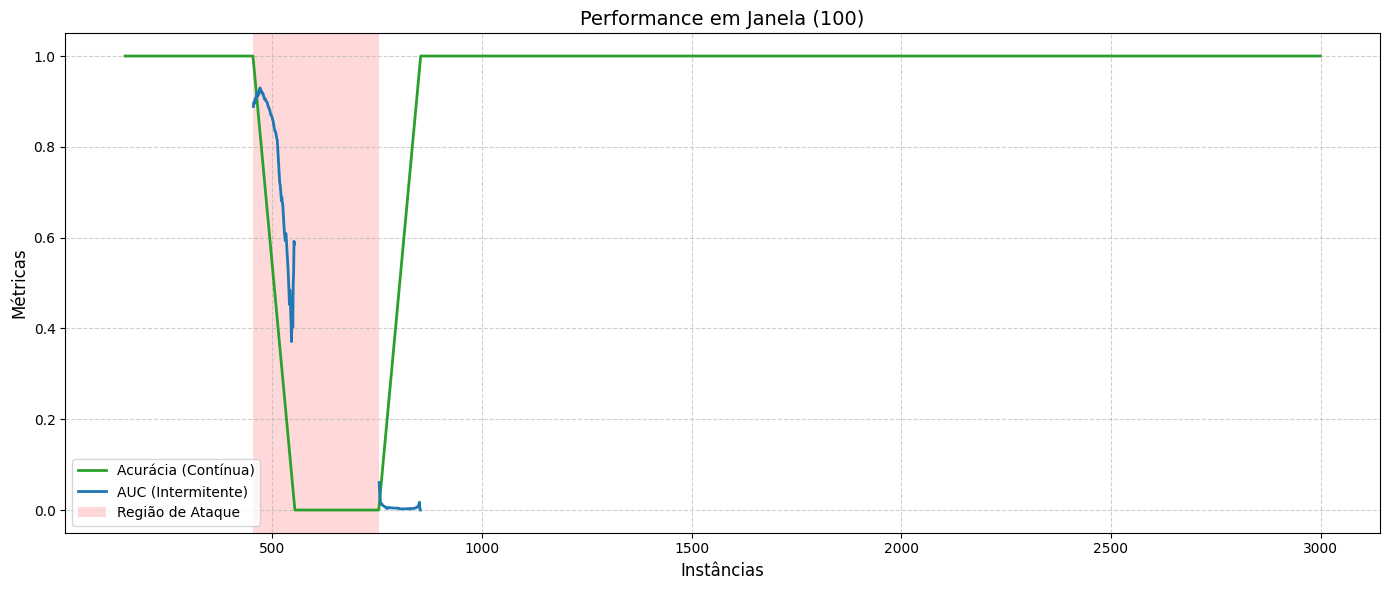

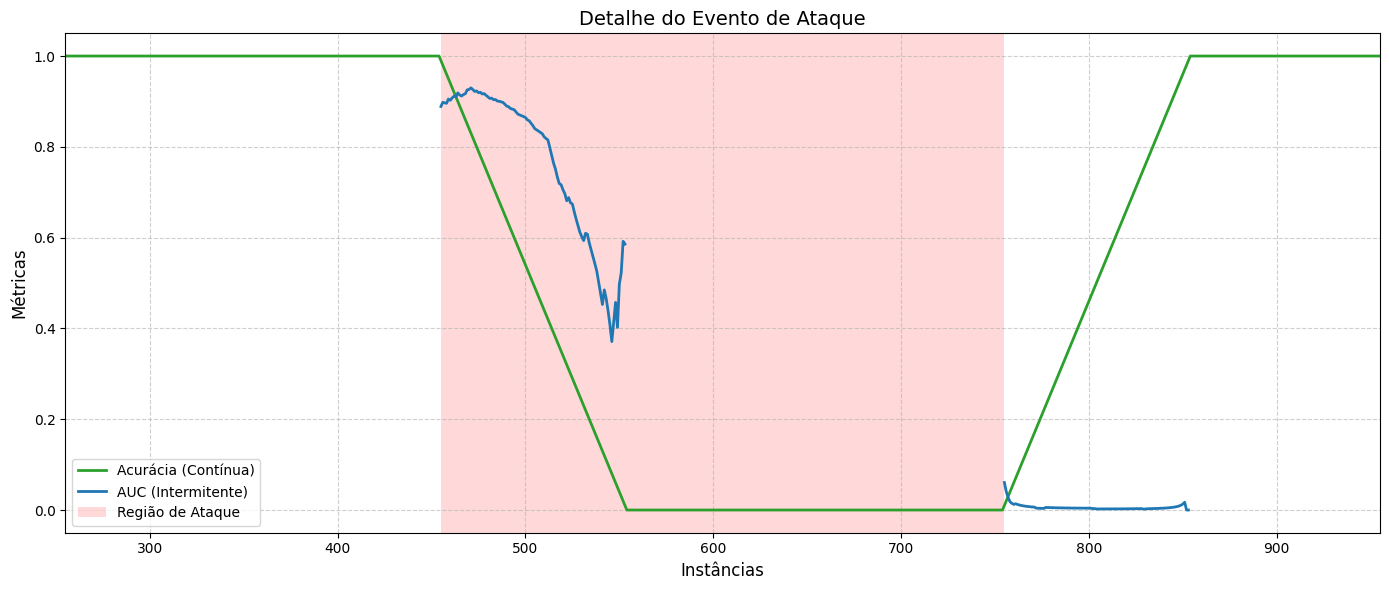

In [38]:
acumulative(
    WARMUP=0
)

slidingWindow(
    WINDOW_SIZE=100, 
    WARMUP=50, 
    PROTECTION_THRESHOLD=0.7
)
